In [56]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import sys, os
sys.path.append('../../src/')
# import toolbox
from toolbox import *

In [79]:
# Choose copula by AIC

result_names = ['BBT_Tiingo',
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',
                'BBT_future_BITX',
                'BBT_future_BITW20', 
                'BBT_future_BITW70', 
                'BBT_future_BITW100', 
                'BBT_future_CRIX']

# result_names = ['BBT_future_CRIX']

coin_names = ['btc', 'ada', 'eth', 'ltc', 'xrp',
              'BITX', 'BITW20', 'BITW70', 'BITW100', 'CRIX']

NIG_coin_names =  ['btc', 'ada', 'eth', 'ltc', 'xrp',
              'bitx', 'bitw20', 'bitw70', 'bitw100', 'CRIX']

result_coin_mapper = dict(zip(result_names, coin_names))

# l = pd.read_json('../../results/BBT_future_Tiingo_ada/MM/likelihood.json') # likelihood 
# l = pd.read_json('../../results/BBT_future_CRIX/MM/likelihood.json') # likelihood 
# l *= 300 # 300 data points
# l = l.iloc[[0,1,3,4,5,6,7]] #remove t copula capped

In [171]:
k = {'Gaussian':1,
     't_Copula':2, 
     't_Copula_Capped':2, 
     'Clayton':1, 
     'Frank':1, 
     'Gumbel':1,  
     'Plackett':1,  
     'Gauss Mix Indep':2, 
     'rotGumbel':1, 
     'NIG':3}

# k = {'Gaussian':0,
#      't_Copula':0, 
#      't_Copula_Capped':0, 
#      'Clayton':0, 
#      'Frank':0, 
#      'Gumbel':0,  
#      'Plackett':0,  
#      'Gauss Mix Indep':0, 
#      'NIG':0}

copula_names = list(k.keys())

def AIC_table(l, drop_t_Copula_Capped=True):
    # l likelihood table
    if drop_t_Copula_Capped:
        l = l.drop(index='t_Copula_Capped')
       
    copula_names = list(l.index)
    AIC = l.copy()
    
    for c in copula_names:
        AIC.loc[c,:] = -2*l.loc[c,:]+2*k[c]
        
    return AIC

In [172]:
AIC_results = dict()
copula_to_use = dict()
copula_count = dict()

for result in result_names:
    l = pd.read_json('../../results/%s/MM/likelihood_NIG.json'%result) # likelihood 
#     l *=300 # 300 data points
    
    _AIC = AIC_table(l, True)
    AIC_results[result] = _AIC
    
    _copula = _AIC.idxmin(axis='rows')
    _copula = pd.DataFrame(_copula).reset_index()
    _copula.columns = ['file', 'copula']
    copula_to_use[result] = _copula
    

    copula_count[result]= pd.pivot_table(_copula, index=['copula'], aggfunc='count')

In [173]:
_AIC.iloc[:, 0].nsmallest(2).index[1] # second smallest

'Gauss Mix Indep'

In [174]:
copula_count_summary = pd.DataFrame(columns=copula_names)

for rm in result_names:
    c = copula_count[rm]
    c.index.name = None
    c.columns = [result_coin_mapper[rm]]
    copula_count_summary = copula_count_summary.append(c.T)

In [175]:
copula_count_summary = copula_count_summary.fillna(0)

In [176]:
copula_count_summary = pd.concat([copula_count_summary.loc[:,c] for c in copula_names if c != 't_Copula_Capped'],
          axis=1)

In [177]:
copula_count_summary.loc['sum',:] = copula_count_summary.sum()

In [178]:
copula_count_summary = copula_count_summary.astype(np.int)
# _index = ['btc','eth','ada','ltc','xrp','BITX','CRIX','BITW100','BITW20','BITW70']

# copula_count_summary.reindex(_index)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [179]:
_index = ['btc','eth','ada','ltc','xrp','BITX','CRIX','BITW100','BITW20','BITW70']
# print(copula_count_summary.reindex(_index).to_latex())
copula_count_summary.reindex(_index)

,Gaussian,t_Copula,Clayton,Frank,Gumbel,Plackett,Gauss Mix Indep,rotGumbel,NIG
btc,0,73,0,0,1,4,2,1,31
eth,0,3,0,0,0,6,8,94,1
ada,0,0,0,0,0,0,0,0,112
ltc,0,13,0,0,0,0,3,32,64
xrp,0,0,0,0,0,31,3,78,0
BITX,0,39,0,0,0,0,14,16,12
CRIX,0,47,0,0,0,0,11,3,27
BITW100,0,42,0,0,0,0,8,29,2
BITW20,0,0,0,0,0,0,0,78,3
BITW70,0,0,0,0,0,0,0,80,1


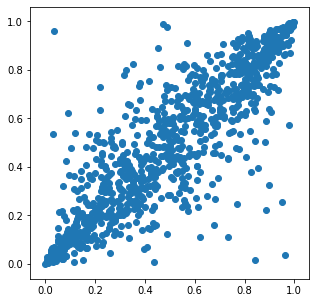

In [180]:
# check T MSE in eth t copula vs gauss mix indep
# explain why GMI is more popular than t copula in eth
# 1. off diagonal noise is managed by the ind 
# 2. 
# 3. Plackett has no tail but some 
# 4. NIG: Indpendence + Tail + Asymmetry; compare with double-t

sys.path.append('../../src/')
from copulae1 import *
# stats.uniform
C = t_Copula({'rho':0.9, 'nu':2}, stats.uniform, stats.uniform, 2)
s = C.sample(1000)

plt.figure(figsize=(5,5))
plt.scatter(s[:,0], s[:,1])

In [181]:
_index = ['btc','eth','ada','ltc','xrp','BITX','CRIX','BITW100','BITW20','BITW70']
copula_count_summary.reindex(_index)

,Gaussian,t_Copula,Clayton,Frank,Gumbel,Plackett,Gauss Mix Indep,rotGumbel,NIG
btc,0,73,0,0,1,4,2,1,31
eth,0,3,0,0,0,6,8,94,1
ada,0,0,0,0,0,0,0,0,112
ltc,0,13,0,0,0,0,3,32,64
xrp,0,0,0,0,0,31,3,78,0
BITX,0,39,0,0,0,0,14,16,12
CRIX,0,47,0,0,0,0,11,3,27
BITW100,0,42,0,0,0,0,8,29,2
BITW20,0,0,0,0,0,0,0,78,3
BITW70,0,0,0,0,0,0,0,80,1


In [182]:
# Order of NIG's h Variance	VaR 99%	VaR 95%	ES 99%	ES 95%	Spectral 10

for i in range(len(result_names)):
    _OHR = pd.read_csv('../../results/%s/MM/OHR.csv'%result_names[i])
    _OHR = _OHR.iloc[:,1:]

    NIG_path = '../../_mathematica/data_%s/'%NIG_coin_names[i]
    ls = os.listdir(NIG_path)

    NIG_h_ls = [l for l in ls if l.endswith('_h.csv')]

    for j in range(len(NIG_h_ls)):
        file_name = NIG_h_ls[j].replace('_h', '')
        risk_measures_NIG = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 
                             'ES q=0.01', 'ES q=0.05', 'ERM k=10']

        NIG_h = pd.read_csv(NIG_path+NIG_h_ls[j], skipfooter=1)

        NIG_h.columns = ['OHR']
        NIG_h.loc[:,'risk measure'] = risk_measures_NIG
        NIG_h.loc[:, 'file'] = file_name
        NIG_h.loc[:, 'copula'] = 'NIG'
        _OHR = _OHR.append(NIG_h)

    _OHR = _OHR.sort_values(['file', 'risk measure'])
    _OHR.reset_index(drop=True, inplace=True)
    _OHR.to_csv('../../results/%s/MM/OHR_NIG.csv'%result_names[i])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


'2020-12-11 21:00:00+00:00'

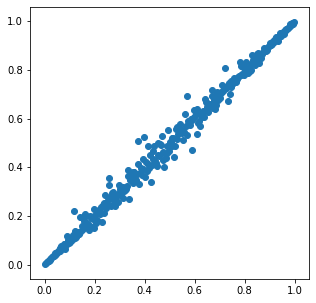

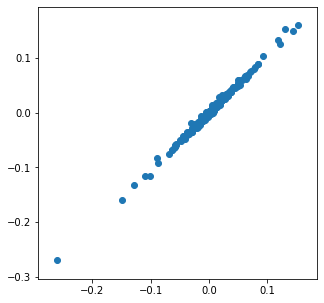

In [183]:
df = pd.read_csv('../../processed_data/BBT_Tiingo/train/22.csv')

rs = df.loc[:,'log return bitcoin']
rf = df.loc[:,'log return future']

import matplotlib.pyplot as plt
import os, sys
sys.path.append('../../src/')
import toolbox
import KDEs as K

kde_rs = K.KDE(rs, 'Gaussian')
kde_rf = K.KDE(rf, 'Gaussian')

u = kde_rs.cdf(rs)
v = kde_rf.cdf(rf)
plt.figure(figsize=(5,5))
plt.scatter(u, v)

plt.figure(figsize=(5,5))
plt.scatter(rs, rf)
df.Date.iloc[0]

In [184]:
copula_to_use[result_names[0]]

,file,copula
0,97.csv,NIG
1,83.csv,NIG
2,68.csv,t_Copula
3,6.csv,t_Copula
4,54.csv,Gauss Mix Indep
5,40.csv,Gauss Mix Indep
6,41.csv,t_Copula
7,7.csv,t_Copula
8,55.csv,t_Copula
9,69.csv,t_Copula


In [185]:
OHR = pd.read_csv('../../results/%s/MM/OHR.csv'%result_names[0])

In [186]:
risk_measures = list(np.unique(OHR.loc[:, 'risk measure']))
# ctu.copula

In [187]:
for rn in result_names:
    OHR = pd.read_csv('../../results/%s/MM/OHR_NIG.csv'%rn)
    ctu = copula_to_use[rn]

    for rm in risk_measures:
        rh_df = pd.DataFrame()

        for i in range(len(ctu)):
            file = ctu.file[i]
            c = ctu.copula[i]

            _id = (OHR.file==file) & (OHR.copula==c) & (OHR.loc[:,'risk measure']==rm)
            if sum(_id)==0:
                continue
            h = OHR.loc[_id,'OHR'].values[0]

            # Load testing data
            test_df = pd.read_csv('../../processed_data/%s/test/%s'%(rn, file))

            Date = test_df.Date
            rs = test_df.iloc[:,-1]
            rf = test_df.iloc[:,-2]
            rh = rs - h*rf

            rh = pd.DataFrame({'Date':Date, 'rh':rh, 'rs':rs, 'rf':rf, 'h':h, 'copula':c})
            rh_df = rh_df.append(rh)

        rh_df.Date = pd.to_datetime(rh_df.Date)
        rh_df.sort_values('Date', ascending=False, inplace=True)
        rh_df.to_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(rn, rm))

In [157]:
pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(result_names[3],
                                                              'VaR q=0.05'))

,Unnamed: 0,Date,rh,rs,rf,h,copula
0,0,2021-05-27 20:00:00+00:00,0.009750,0.016519,0.006583,1.028196,NIG
1,1,2021-05-26 20:00:00+00:00,0.095467,0.129031,0.032643,1.028196,NIG
2,2,2021-05-25 20:00:00+00:00,-0.002928,-0.066928,-0.062245,1.028196,NIG
3,3,2021-05-24 20:00:00+00:00,-0.055044,0.041945,0.094330,1.028196,NIG
4,4,2021-05-21 20:00:00+00:00,-0.072373,-0.184250,-0.108809,1.028196,NIG
5,0,2021-05-20 20:00:00+00:00,0.015686,0.037395,0.021291,1.019631,NIG
6,1,2021-05-19 20:00:00+00:00,-0.283672,-0.375913,-0.090465,1.019631,NIG
7,2,2021-05-18 20:00:00+00:00,0.065614,0.045533,-0.019694,1.019631,NIG
8,3,2021-05-17 20:00:00+00:00,-0.005504,-0.139733,-0.131645,1.019631,NIG
9,4,2021-05-14 20:00:00+00:00,0.048361,0.085934,0.036850,1.019631,NIG


In [158]:
pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(result_names[3],
                                                              'ERM k=10'))

,Unnamed: 0,Date,rh,rs,rf,h,copula
0,0,2021-05-27 20:00:00+00:00,0.009019,0.016519,0.006583,1.139203,NIG
1,1,2021-05-26 20:00:00+00:00,0.091844,0.129031,0.032643,1.139203,NIG
2,2,2021-05-25 20:00:00+00:00,0.003981,-0.066928,-0.062245,1.139203,NIG
3,3,2021-05-24 20:00:00+00:00,-0.065516,0.041945,0.094330,1.139203,NIG
4,4,2021-05-21 20:00:00+00:00,-0.060295,-0.184250,-0.108809,1.139203,NIG
5,0,2021-05-20 20:00:00+00:00,0.015029,0.037395,0.021291,1.050498,NIG
6,1,2021-05-19 20:00:00+00:00,-0.280879,-0.375913,-0.090465,1.050498,NIG
7,2,2021-05-18 20:00:00+00:00,0.066222,0.045533,-0.019694,1.050498,NIG
8,3,2021-05-17 20:00:00+00:00,-0.001441,-0.139733,-0.131645,1.050498,NIG
9,4,2021-05-14 20:00:00+00:00,0.047224,0.085934,0.036850,1.050498,NIG


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


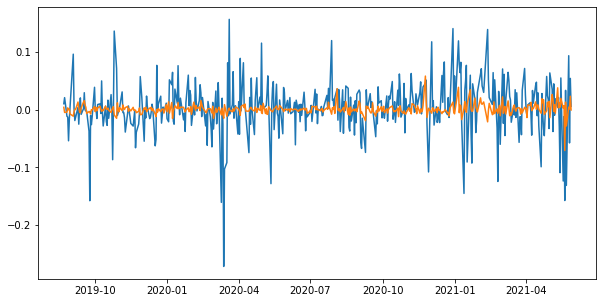

In [247]:
plt.figure(figsize=(10,5))
plt.plot(rh_df.Date, rh_df.rs)
plt.plot(rh_df.Date, rh_df.rh)

In [188]:
name = 'BBT_future_Tiingo_xrp'
ctu = copula_to_use[name]

train = pd.read_csv('../../processed_data/%s/train/%s'%(name, '0.csv'))

train.head()

,Unnamed: 0,Date,PX_LAST,contract_name,xrp Price,log return future,log return xrp
0,5,2021-05-20 20:00:00+00:00,40350.0,BTCM1 Curncy,1.182123,0.021291,0.014197
1,6,2021-05-19 20:00:00+00:00,39500.0,BTCM1 Curncy,1.165459,-0.090465,-0.304108
2,7,2021-05-18 20:00:00+00:00,43240.0,BTCM1 Curncy,1.579682,-0.019694,0.031345
3,8,2021-05-17 20:00:00+00:00,44100.0,BTCM1 Curncy,1.530934,-0.131645,0.102715
4,9,2021-05-14 20:00:00+00:00,50305.0,BTCM1 Curncy,1.381491,0.036850,0.093586


In [189]:
# name = 'BBT_future_BITW70'
# ctu = copula_to_use[name]
# ctu.head()

In [190]:
training_Clayton = pd.DataFrame()
training = pd.DataFrame()
for i in range(len(ctu)):
    row = ctu.iloc[i, :]
    file = row.file
    df = pd.read_csv('../../processed_data/%s/train/%s'%(name, file))
    training = training.append(df)
    if row.copula == 'Clayton':
        training_Clayton = training_Clayton.append(df)
        
training_Clayton = training_Clayton.drop_duplicates('Date')
training_Clayton.Date = pd.to_datetime(training_Clayton.Date)
training_Clayton.sort_values('Date', inplace=True)

training = training.drop_duplicates('Date')
training.Date = pd.to_datetime(training.Date)
training.sort_values('Date', inplace=True)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


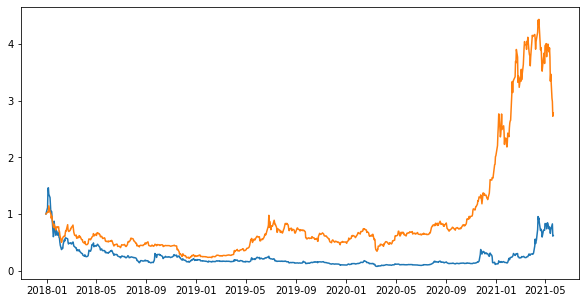

In [191]:
future = training.loc[:,'PX_LAST']
# spot = training.loc[:,'BITW70 Price']

spot = training.loc[:,'xrp Price']
date = training.Date

plt.figure(figsize=(10,5))
plt.plot(date, spot/spot.iloc[0])
plt.plot(date, future/future.iloc[0])

# plt.plot(training_Clayton.Date, training_Clayton.loc[:, 'xrp Price']/xrp.iloc[-1])
# plt.plot(date, future/future.iloc[-1])

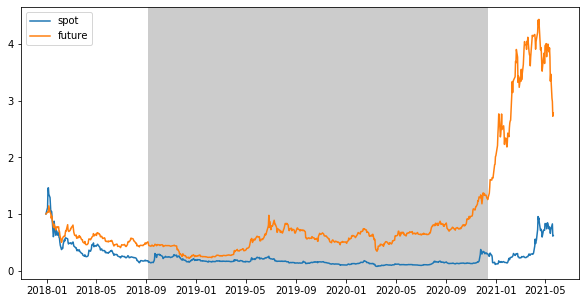

In [192]:
plt.figure(figsize=(10,5))
plt.plot(date, spot/spot.iloc[0], label='spot')
plt.plot(date, future/future.iloc[0], label='future')

_start = training_Clayton.Date.iloc[0]
_end = 0
for i in range(len(training_Clayton)-1):
    start = training_Clayton.Date.iloc[i]
    end =  training_Clayton.Date.iloc[i+1]
    _end = end
    plt.axvspan(start, end,facecolor='black', alpha=.2)
plt.legend()
plt.savefig('../../latex/Figures/Tables/xrp_timeseries.pdf', transparent=True)

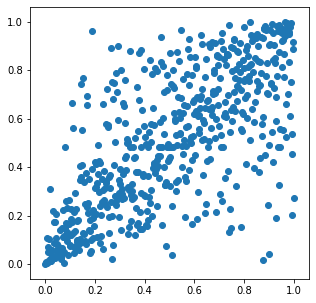

In [193]:
# rs = train.loc[:,'log return xrp']
# rf = train.loc[:,'log return future']
rs = np.array(training_Clayton.iloc[:, -1])
rf = np.array(training_Clayton.iloc[:, -2])

kde_rs = K.KDE(rs, 'Gaussian')
kde_rf = K.KDE(rf, 'Gaussian')

u = kde_rs.cdf(rs)
v = kde_rf.cdf(rf)

plt.figure(figsize=(5,5))
plt.scatter(u,v)

Text(0.5, 0, '$q$')

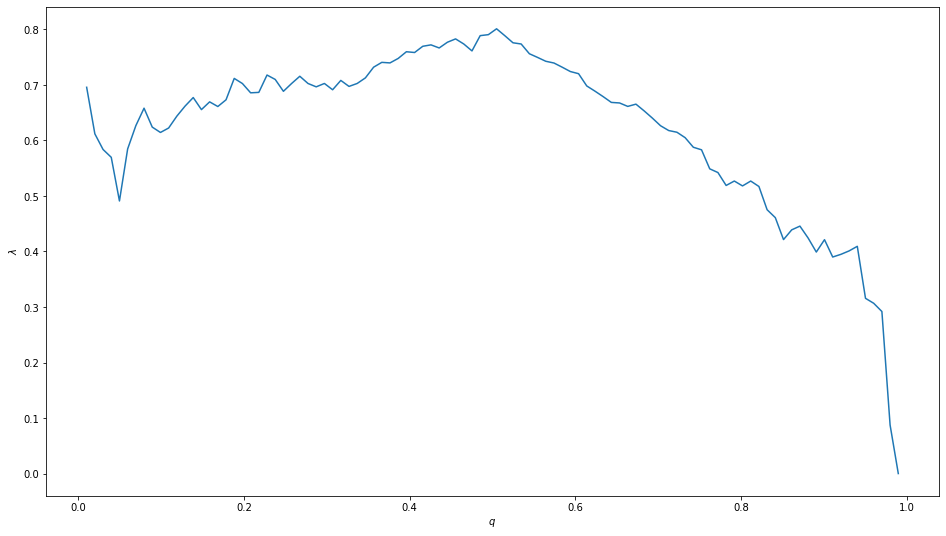

In [194]:
plt.figure(figsize=(16,9))
q_arr = np.linspace(0.01,0.99,100)
plt.plot(q_arr, [empirical_lambda(ECDF(rs)(rs), ECDF(rf)(rf), q) for q in q_arr])

plt.ylabel(r'$\lambda$')
plt.xlabel(r'$q$')

In [195]:
C1 = Gaussian(dict(rho=0.9), Law_RS=stats.norm, Law_RF=stats.norm)  # fix the maringals!
C2 = t_Copula(dict(rho=0.1, nu=4), Law_RS=stats.norm, Law_RF=stats.norm, nu_lowerbound=2)
# C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=stats.norm, Law_RF=stats.norm, nu_lowerbound=4)
C3 = Clayton(dict(theta=0.1), Law_RS=stats.norm, Law_RF=stats.norm)
C4 = Frank(dict(theta=0.1), Law_RS=stats.norm, Law_RF=stats.norm)
C5 = Gumbel(dict(theta=3), Law_RS=stats.norm, Law_RF=stats.norm)
C6 = Plackett(dict(theta=10), Law_RS=stats.norm, Law_RF=stats.norm)
C7 = Gaussian_Mix_Independent(dict(rho=.5, p=0.7), Law_RS=stats.norm, Law_RF=stats.norm)

In [196]:
from KDEs import *

kde_brr = KDE(rs, "Gaussian")
kde_btc = KDE(rf, "Gaussian")

In [197]:
q_arr = [0.05,0.1,0.9,0.95]

u = ECDF(rs)(rs)
v = ECDF(rf)(rf)
Copulae_names = ['Gaussian', 't_Copula', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr = [C1, C2, C3, C4, C5, C6, C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))
for C_name in Copulae:
    if (C_name == 't_Copula') or (C_name == 't_Copula_Capped'):
        Copulae[C_name].__init__(Copulae[C_name].paras, kde_brr, kde_btc, nu_lowerbound=2.001)
        Copulae[C_name].mm_calibrate(u,v,q_arr)
    else:
        Copulae[C_name].__init__(Copulae[C_name].paras, kde_brr, kde_btc)
        Copulae[C_name].mm_calibrate(u,v,q_arr)

../../src/copulae1.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m_hat = np.array([self.tau()] + [self._lambda(q) for q in q_arr])


Optimization terminated successfully.
         Current function value: 0.035132
         Iterations: 34
         Function evaluations: 72


../../src/toolbox.py:55: RuntimeWarning: overflow encountered in double_scalars
  fn = lambda s: s ** (self.nu - 1) * np.exp(-s ** 2 / 2) * self.MN.cdf(s * b / np.sqrt(self.nu))
../../src/toolbox.py:55: RuntimeWarning: invalid value encountered in double_scalars
  fn = lambda s: s ** (self.nu - 1) * np.exp(-s ** 2 / 2) * self.MN.cdf(s * b / np.sqrt(self.nu))
../../src/toolbox.py:56: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return 2 ** (1 - (self.nu / 2)) / gamma(self.nu / 2) * scipy.integrate.quad(fn, 0, np.inf)[0]


Optimization terminated successfully.
         Current function value: 0.035338
         Iterations: 183
         Function evaluations: 358
Optimization terminated successfully.
         Current function value: 0.111144
         Iterations: 42
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 0.058687
         Iterations: 48
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: 0.211476
         Iterations: 36
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 0.036803
         Iterations: 41
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 0.034969
         Iterations: 108
         Function evaluations: 211


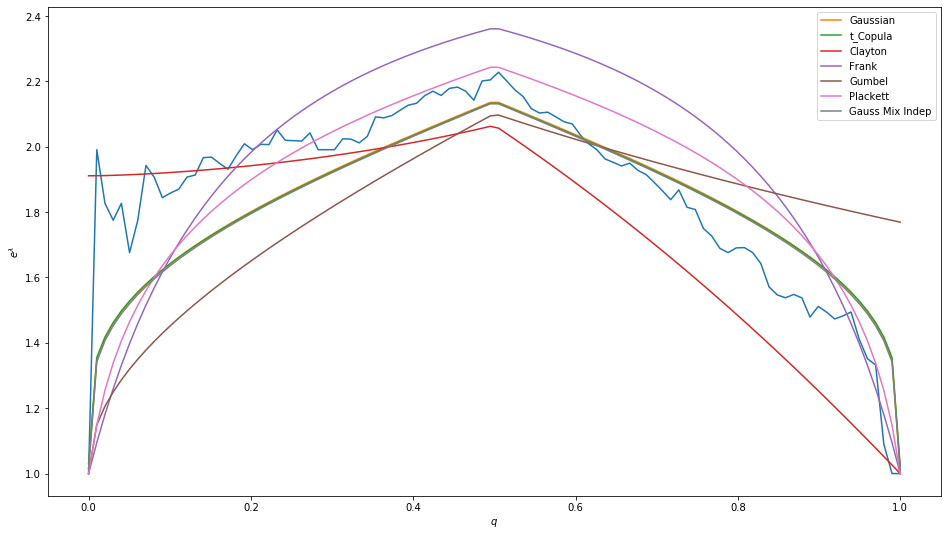

In [198]:
plt.figure(figsize=(16,9))
q_arr = np.linspace(0.000000001,0.9999999999,100)
plt.plot(q_arr, np.exp([empirical_lambda(ECDF(rs)(rs), ECDF(rf)(rf), q) for q in q_arr]))

for C_name in Copulae:
    plt.plot(q_arr, np.exp([Copulae[C_name]._lambda(q) for q in q_arr]), label=C_name)
    
plt.legend()
plt.ylabel(r'$e^\lambda$')
plt.xlabel(r'$q$')

plt.savefig('../../latex/Figures/Tables/xrp_quantile_dependence.pdf', transparent=True)


$C_{180}(u_1, u_2)=u_1+u_2-1+C(1-u_1,1-u_2)$

In [199]:
q_arr = [0.05,0.1,0.9,0.95]
C5.mm_calibrate(1-u, 1-v, q_arr)
# C5.canonical_calibrate(1-u, 1-v)

Optimization terminated successfully.
         Current function value: 0.015525
         Iterations: 31
         Function evaluations: 66


array([1.97038307])

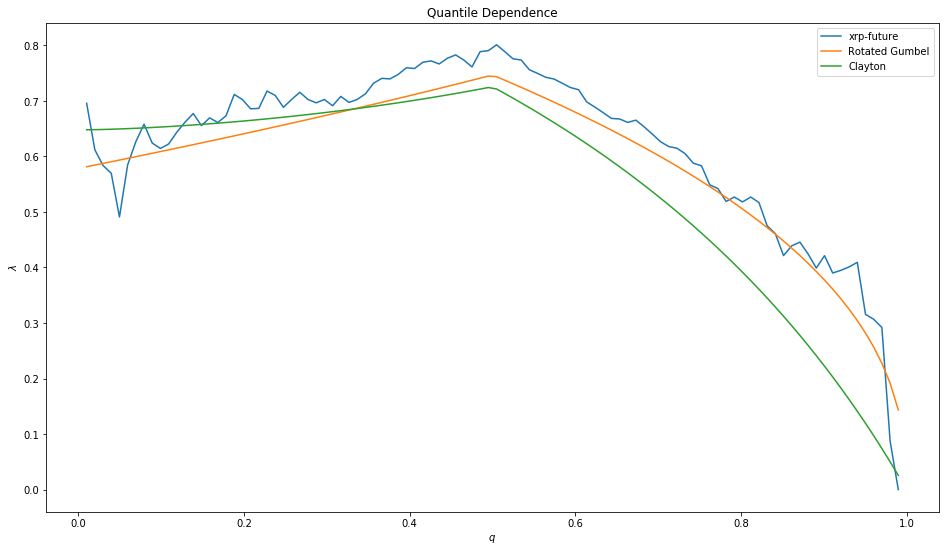

In [200]:
plt.figure(figsize=(16,9))
q_arr = np.linspace(0.01,0.99,100)
plt.title('Quantile Dependence')
plt.plot(q_arr, ([empirical_lambda(ECDF(rs)(rs), ECDF(rf)(rf), q) for q in q_arr]), label='xrp-future')
plt.plot(1-q_arr, ([C5._lambda(q) for q in q_arr]), label='Rotated Gumbel')
plt.plot(q_arr, [C3._lambda(q) for q in q_arr], label='Clayton')
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$q$')
plt.legend()
plt.savefig('../../latex/Figures/Tables/xrp_rotated_gumbel_vs_clayton.pdf', transparent=True)


Asymetric: Gumbel, Clayton, NIG, Rotated Gumbel --> Financial Data stylized fact
Symetric: Gaussian, t, Gauss Mix Indep, Frank, Plackett

Upper Tail Dependence: Gumbel, t, NIG? (check whether it is heavy tail)
Lower Tail Dependence: Rotated Gumbel, Clayton, t, NIG? 

Gauss Mix Indep controls off diagonal by p 
t rho and nu 

Insight for Plackett? we can be open: "we considered Plackett, but it does not bring insight"

../../src/toolbox.py:294: RuntimeWarning: invalid value encountered in power
  part2 = np.sin(self.alpha * (U + xi)) / (np.cos(U) ** (1 / self.alpha))
../../src/toolbox.py:295: RuntimeWarning: invalid value encountered in power
  part3 = (np.cos(U - self.alpha * (U + xi)) / W) ** ((1 - self.alpha) / self.alpha)


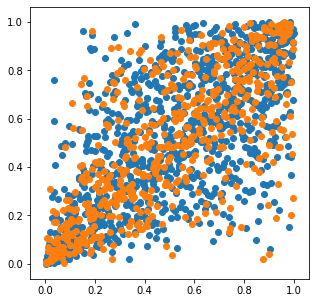

In [201]:
s = C5.sample(1000)

a = ECDF(s[:,0])(s[:,0])
b = ECDF(s[:,1])(s[:,1])
plt.figure(figsize=(5,5))
plt.scatter(1-a, 1-b)
plt.scatter(u,v)

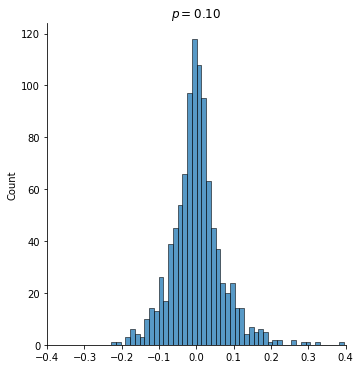

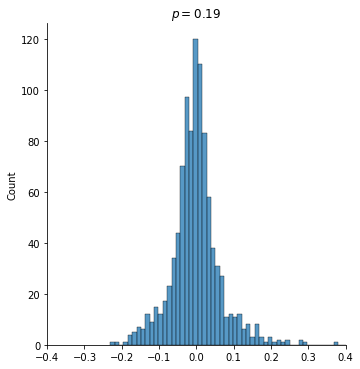

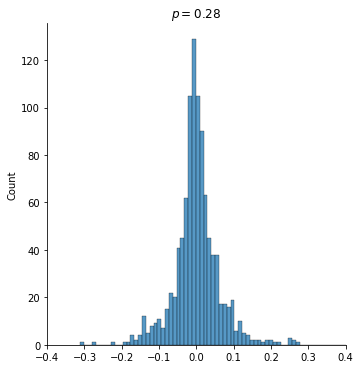

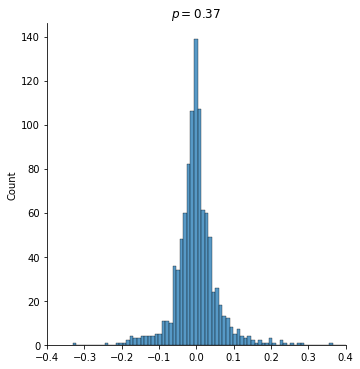

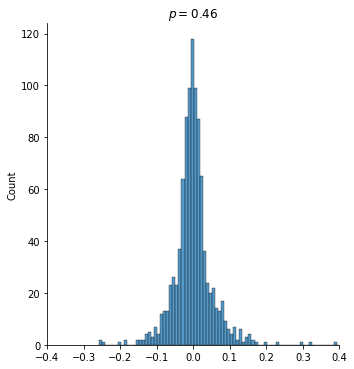

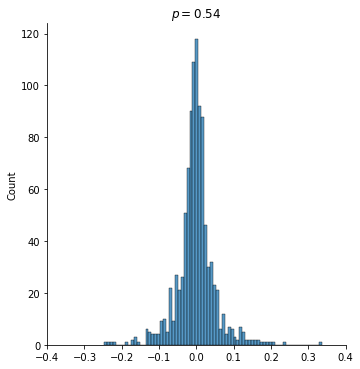

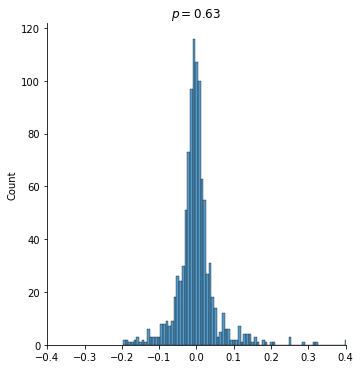

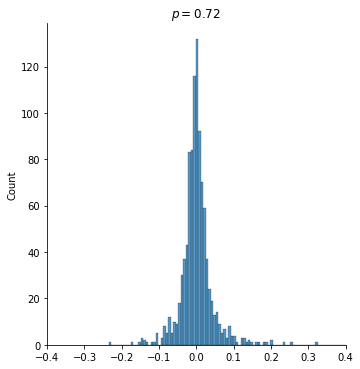

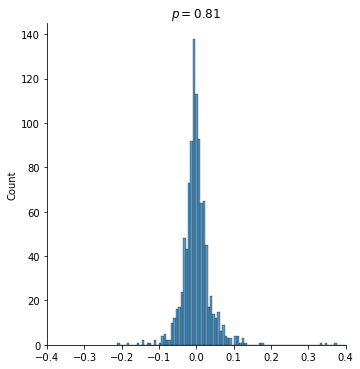

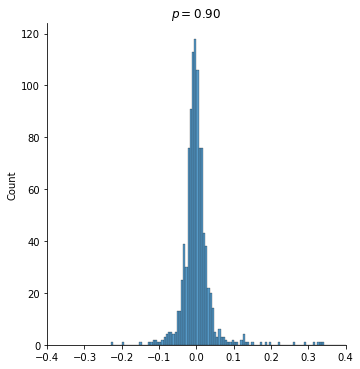

In [403]:
# Effect of adding independent noise

kde_brr = KDE(rs, "Gaussian")
kde_btc = KDE(rf, "Gaussian")

p_arr = np.linspace(0.1,0.9,10)
for p in p_arr:
    C7a = Gaussian_Mix_Independent(dict(rho=.9, p=p), kde_brr, kde_btc)
    s = C7a.sample(1000)
    
    rh = s[:,0] - s[:,1]
    sns.displot(rh)
    plt.title(r'$p=%.2f$'%p)
    plt.xlim((-0.4,0.4))
    
#     a = ECDF(s[:,0])(s[:,0])
#     b = ECDF(s[:,1])(s[:,1])
#     plt.figure(figsize=(5,5))
#     plt.scatter(a, b)

In [408]:
data_name = 'BBT_future_Tiingo_xrp'
paras = pd.read_json("../../results/" + data_name + "/MM/parameters.json")
paras.iloc[-1,:]

97.csv              {'rho': 0.8683605617, 'p': 0.8811250656}
83.csv        {'rho': 0.9210003280000001, 'p': 0.7318263372}
68.csv        {'rho': 0.9110229270000001, 'p': 0.7537363423}
6.csv                      {'rho': 0.6174915606, 'p': 0.999}
54.csv              {'rho': 0.8288288055, 'p': 0.8472480154}
40.csv                     {'rho': 0.7226808324, 'p': 0.999}
41.csv                     {'rho': 0.7309834508, 'p': 0.999}
7.csv                      {'rho': 0.6210739544, 'p': 0.999}
55.csv              {'rho': 0.8435502599, 'p': 0.8304737221}
69.csv        {'rho': 0.9164836515, 'p': 0.7417549010000001}
82.csv     {'rho': 0.9180471358000001, 'p': 0.73832055390...
96.csv               {'rho': 0.8295810629, 'p': 0.920083352}
80.csv        {'rho': 0.8636209754, 'p': 0.7824518300000001}
94.csv              {'rho': 0.8941695213, 'p': 0.8415273646}
43.csv              {'rho': 0.7972322099, 'p': 0.9170773311}
57.csv              {'rho': 0.8285351649, 'p': 0.8329510892}
5.csv                   